# GENERATING A SYNTHETIC GRAPH

## Preliminaries

In [103]:
pip install torch

You should consider upgrading via the 'C:\Users\noure\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
#Libraries
import networkx as nx 
import random           # for randomly assigning edge directions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Goods-Flow Directed Graph (BA)

In [4]:
def generate_goods_flow_graph(n,m):
    """ 
    Description:
        Creates a directed graph that has been generated using the BA model. Nodes represent companies, and links represent an exchange of 
        goods from one to another.

    Args:
        n = total number of nodes of the graph
        m = number of nodes to which a node attaches when introduced to the network.

    Returns:
        G = the original BA undirected graph
        DG = the undirected graph
    
    """
    G = nx.barabasi_albert_graph(n,m)            # undirected BA graph
    G.remove_edges_from(nx.selfloop_edges(G))
    G.remove_nodes_from(list(nx.isolates(G)))
    DG = nx.DiGraph()                            # empty directed graph
    DG.add_nodes_from(G.nodes())           # add nodes in G
    # build directed graph (one link per pair)
    for u,v in list(G.edges()):
        if random.random() < 0.5:                # random returns a random number between 0 and 1
            DG.add_edge(u,v, edge_type= 'goods') # edge: u --> v
        else:
            DG.add_edge(v,u, edge_type= 'goods') # edge:v--> u
    
    return G, DG

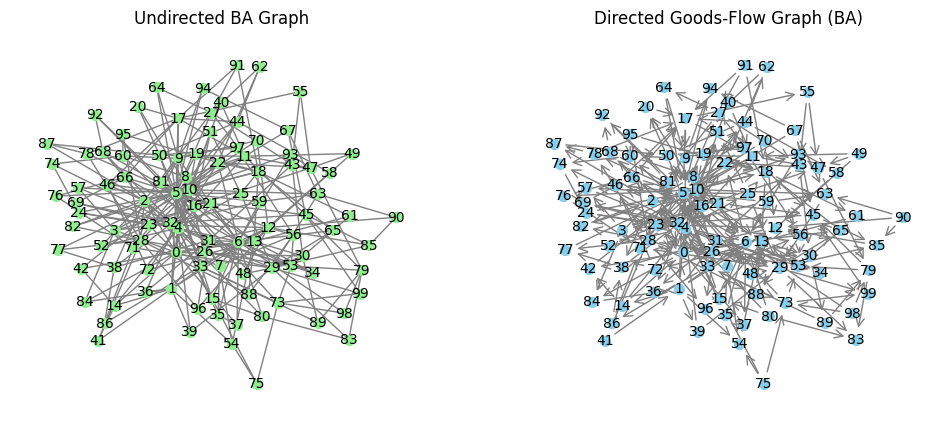

In [5]:
BA_graph, goodsFlow = generate_goods_flow_graph(100, 3)

pos = nx.spring_layout(BA_graph, seed=42)

# --- Plot undirected BA graph ---
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(BA_graph, pos, node_size=50, node_color='lightgreen')
nx.draw_networkx_edges(BA_graph, pos, edge_color='gray')
nx.draw_networkx_labels(BA_graph, pos, font_size=10)
plt.title("Undirected BA Graph")
plt.axis('off')

# --- Plot directed goods-flow graph ---
plt.subplot(1, 2, 2)
nx.draw_networkx_nodes(goodsFlow, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(goodsFlow, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_labels(goodsFlow, pos, font_size=10)
plt.title("Directed Goods-Flow Graph (BA)")
plt.axis('off')

plt.show()

## Graph With Goods-Flow and Repayment-Flow

In [6]:
def add_node_features(G, seed = 42):
    """
    Description:
        For each node in the graph, it assigns its attributes randomly from probability distributions.
    Args:
        Graph
    Return:
        Graph with node attributes
    """
    TD = G.copy()
    np.random.seed(seed=40)
    
    for node in TD.nodes():
        # Cash flow: log-normal
        TD.nodes[node]['cash_flow'] = np.random.lognormal(mean=12, sigma=2)
        
        # Debt/Capital ratio: log-normal
        TD.nodes[node]['debt_to_capital'] = np.random.lognormal(mean=-1.1, sigma=2)
        
        # Historical unpaid transactions (fraction between 0 and 1)
        TD.nodes[node]['unpaid_fraction'] = np.random.uniform(0, 1)
        
        # Age of company: normal with mean 18, sigma=5, clipped at 1+
        age = int(np.random.normal(loc=18, scale=5))
        TD.nodes[node]['age'] = max(age, 1)  # ensure age ≥ 1

    return TD

In [7]:
DGN = add_node_features(goodsFlow)
print(DGN.nodes[0])

df = pd.DataFrame.from_dict(dict(DGN.nodes(data=True)), orient='index')
means = df.mean()
minimum = df.min()
maximum = df.max()
sdv = df.std()
print("MEANS----------------------")
print(means)
print("MINIMUM--------------------")
print(minimum)
print("MAXIMUM--------------------")
print(maximum)
print("SPREAD---------------------")
print(sdv)

{'cash_flow': 48286.37001826454, 'debt_to_capital': 0.2586517208868817, 'unpaid_fraction': 0.7885348774867527, 'age': 15}
MEANS----------------------
cash_flow          1.253296e+06
debt_to_capital    3.181443e+00
unpaid_fraction    4.729802e-01
age                1.714000e+01
dtype: float64
MINIMUM--------------------
cash_flow          1074.895923
debt_to_capital       0.003112
unpaid_fraction       0.000427
age                   6.000000
dtype: float64
MAXIMUM--------------------
cash_flow          2.544096e+07
debt_to_capital    8.208708e+01
unpaid_fraction    9.809389e-01
age                3.200000e+01
dtype: float64
SPREAD---------------------
cash_flow          3.213000e+06
debt_to_capital    1.177457e+01
unpaid_fraction    2.708467e-01
age                5.204932e+00
dtype: float64


In [8]:
def graph_node_features_summary(G):
    cols = ['cash_flow', 'debt_to_capital', 'age', 'unpaid_fraction']
    
    data = {col: [] for col in cols}
    
    for _, attrs in G.nodes(data=True):
        for col in cols:
            data[col].append(attrs[col])
    mins = [min(data[col]) for col in cols]
    maxs = [max(data[col]) for col in cols]
    
    return np.array([mins, maxs], dtype=float)

In [9]:
summary = graph_node_features_summary(DGN)
print(summary)
print(summary[0][0])

[[1.07489592e+03 3.11223270e-03 6.00000000e+00 4.26669585e-04]
 [2.54409609e+07 8.20870826e+01 3.20000000e+01 9.80938863e-01]]
1074.8959234362214


In [10]:
def normalized_node_score(G, node):
    summary = graph_node_features_summary(G)
    CF = (G.nodes[node]['cash_flow'] - summary[0][0])/(summary[1][0] - summary[0][0])
    DtC = (G.nodes[node]['debt_to_capital'] - summary[0][1])/(summary[1][1] - summary[0][1])
    AGE = (G.nodes[node]['age'] - summary[0][2])/(summary[1][2] - summary[0][2])
    UNP = G.nodes[node]['unpaid_fraction'] 
    Score = 0.3*CF + 0.3*(1-DtC) + 0.3*(1-UNP) + 0.1*AGE
    return Score

In [12]:
def repayment_probability(G, b):
    B_neighbours_out = list(G.successors(b))
    outDegree = len(B_neighbours_out)
    neigbours_agg_score = 0
    for i in B_neighbours_out:
         neigbours_agg_score +=  normalized_node_score(G,i)
    b_score = normalized_node_score(G, b)
    if outDegree > 0:
        neighbor_term = (1/outDegree) * neigbours_agg_score
    else:
        neighbor_term = 0
        
    p = 0.6*b_score + 0.4*neighbor_term
    return p

In [13]:
def add_repayment_edges(G):
    """
    Adds repayment edges to our directed goods-flow graph.

    Args:
        G (nx.DiGraph): directed goods-flow graph
        threshold (float)

    Returns:
        nx.DiGraph: graph with repayment edges added
    """
    
    DG = G.copy() # copy original graph
    p_vec = []
    for s, b in G.edges:
        p = repayment_probability(G, b)
        p_vec.append(p)
    threshold_20 = np.percentile(p_vec, 20)
    print("Percentil 20:", threshold_20)
        
        
    for s,b in list(G.edges):
        p = repayment_probability(G, b)
        if p > threshold_20:
            DG.add_edge(b,s, edge_type = 'repayment')
    return DG

In [14]:
FullyLinked = add_repayment_edges(DGN)

Percentil 20: 0.4224956128952907


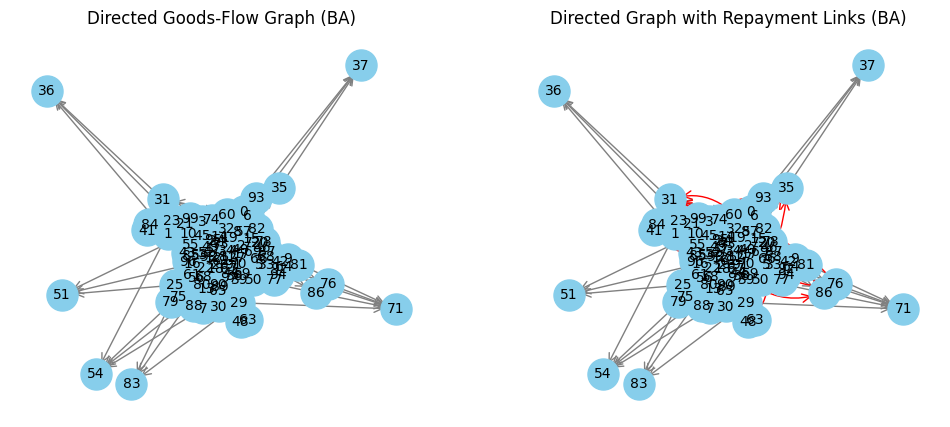

In [15]:
pos = nx.spring_layout(goodsFlow, seed=42)
plt.figure(figsize=(12,5))

# --- Plot directed goods-flow graph ---
plt.subplot(1, 2, 1)
nx.draw_networkx_nodes(goodsFlow, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(goodsFlow, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_labels(goodsFlow, pos, font_size=10)
plt.title("Directed Goods-Flow Graph (BA)")
plt.axis('off')

plt.subplot(1, 2, 2)

# --- Plot directed fully-linked graph ---

# Filter edges by type
goods_edges = []  # start with empty list

for edge in FullyLinked.edges(data=True):
    u = edge[0]       # source node
    v = edge[1]       # target node
    d = edge[2]       # attributes dictionary
    
    if d['edge_type'] == 'goods':  # filter for goods edges
        goods_edges.append((u, v))  # add tuple (u,v) to list

repayment_edges = []  # start with empty list

for edge in FullyLinked.edges(data=True):
    u = edge[0]       # source node
    v = edge[1]       # target node
    d = edge[2]       # attributes dictionary
    
    if d['edge_type'] == 'repayment':  # filter for goods edges
        repayment_edges.append((u, v))  # add tuple (u,v) to list

nx.draw_networkx_nodes(FullyLinked, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(FullyLinked, pos, edgelist=goods_edges, edge_color='gray', arrowstyle='->', arrowsize=15)
nx.draw_networkx_edges(FullyLinked, pos, edgelist=repayment_edges, edge_color='red', arrowstyle='->', arrowsize=15, connectionstyle='arc3, rad=0.3' )
nx.draw_networkx_labels(FullyLinked, pos, font_size=10)
plt.title("Directed Graph with Repayment Links (BA)")
plt.axis('off')

plt.show()

## Adding Node and Edge Features

#### Node features

#### Edge features

In [16]:
def add_edge_features(G, seed = 42):
    """
    Description:
    Adds features to the edges of the graph G.
    
    Features:
    - If edge_type = "goods":
        * invoice_amount: log-normal
        * days_until_due: uniform [1, 90]
        * interest_rate: uniform [0.03, 0.10]
    - If edge_type = "repayment":
        * repayment_amount: uniform [0.5*invoice_amount, invoice_amount] --> at least the insurance company covers half of the transaction amount
        * days_overdue: uniform [0, 90]
    Args: Graph
    Return: graph
    """
    TD = G.copy()
    np.random.seed(seed)
    for u, v, data in TD.edges(data=True):
        edge_type = data.get('edge_type', 'unknown')
        
        if edge_type == 'goods':
            # Invoice amount: log-normal (skewed, positive)
            try:
                if data['invoice_amount'] == None:
                    data['invoice_amount'] = np.random.lognormal(mean=10, sigma=1)
            except:
                data['invoice_amount'] = np.random.lognormal(mean=10, sigma=1)
            
            # Days until due: uniform [1, 90]
            data['days_until_due'] = np.random.uniform(1, 90)
            
            # Interest rate: uniform [0.03, 0.10]
            data['interest_rate'] = np.random.uniform(0.03, 0.10)
            
        else:
            invoice = None
            if TD.has_edge(v, u):
                goods_data = TD[v][u]
                if goods_data.get('edge_type') == 'goods':
                    invoice = goods_data.get('invoice_amount', None)
            if invoice is None: # in case we still haven't filled the goods edge
                invoice = np.random.lognormal(mean=10, sigma=1)
            data['repayment_amount'] = np.random.uniform(0.5*invoice, invoice)
            
            # Days overdue: uniform [0, 90]
            data['days_overdue'] = np.random.uniform(0, 90)
        
    
    return TD
    

In [17]:
TD = add_edge_features(FullyLinked)
edge = list(TD.edges(data=True))[0]
print(edge)

edge_dict = {}
for u, v, attr in TD.edges(data=True):
    edge_dict[(u, v)] = attr

df = pd.DataFrame.from_dict(edge_dict, orient='index')
numeric_df = df.select_dtypes(include='number')
means = numeric_df.mean()
minimum = numeric_df.min()
maximum = numeric_df.max()
sdv = numeric_df.std()
print("MEANS----------------------")
print(means)
print("MINIMUM--------------------")
print(minimum)
print("MAXIMUM--------------------")
print(maximum)
print("SPREAD---------------------")
print(sdv)

(0, 4, {'edge_type': 'goods', 'invoice_amount': 36196.371320026, 'days_until_due': 66.14746082121505, 'interest_rate': 0.07190609389379257})
MEANS----------------------
invoice_amount      35477.479659
days_until_due         42.008012
interest_rate           0.064242
repayment_amount    25629.861477
days_overdue           47.734176
dtype: float64
MINIMUM--------------------
invoice_amount      1275.964165
days_until_due         1.439658
interest_rate          0.030403
repayment_amount     775.578965
days_overdue           0.879376
dtype: float64
MAXIMUM--------------------
invoice_amount      284954.426164
days_until_due          88.722890
interest_rate            0.099799
repayment_amount    156592.515981
days_overdue            89.718683
dtype: float64
SPREAD---------------------
invoice_amount      39633.555102
days_until_due         26.440443
interest_rate           0.019994
repayment_amount    25812.973291
days_overdue           24.975816
dtype: float64


## Saving the Graph